# Modeling

In [44]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score ,roc_curve,auc,f1_score, precision_recall_curve

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('winequality-red-scaled2.csv')

In [46]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.526823,0.967437,-1.396766,-0.468591,-0.286544,-0.472221,-0.389808,0.602517,1.336203,-0.586360,1,0
1,-0.295502,1.980100,-1.396766,-0.085050,0.023186,0.885977,0.615217,0.052556,-0.727179,0.108276,1,0
2,-0.295502,1.304992,-1.191446,-0.249425,-0.061286,-0.084165,0.219298,0.162548,-0.327815,-0.065383,1,0
3,1.670732,-1.395443,1.477714,-0.468591,-0.300623,0.109864,0.402030,0.712509,-0.993422,-0.470587,1,0
4,-0.526823,0.742401,-1.396766,-0.523383,-0.300623,-0.278193,-0.207076,0.602517,1.336203,-0.586360,1,0


In [47]:
df['alcohol'].value_counts()

1    637
2    594
0    128
Name: alcohol, dtype: int64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   int64  
 11  quality               1359 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 127.5 KB


In [49]:
#from sklearn.preprocessing import LabelEncoder
#labelencoder_y = LabelEncoder()
#df['quality'] = labelencoder_y.fit_transform(df['quality'])

# Outlier Treatment

In [288]:
from scipy import stats
z = np.abs(stats.zscore(df))
print(z)

[[0.52682343 0.96743718 1.39676632 ... 0.58636019 0.53312285 0.3957218 ]
 [0.29550184 1.98010018 1.39676632 ... 0.10827601 0.53312285 0.3957218 ]
 [0.29550184 1.30499151 1.19144627 ... 0.06538304 0.53312285 0.3957218 ]
 ...
 [1.39427938 0.12355134 0.88346619 ... 0.57136682 1.02162813 0.3957218 ]
 [1.39427938 0.65801237 0.78080617 ... 0.28193507 1.02162813 0.3957218 ]
 [1.33644898 1.22666599 1.01574428 ... 0.00749669 1.02162813 0.3957218 ]]


In [289]:
threshold = 3
print(np.where(z > 3))

(array([   8,   11,   12,   12,   12,   12,   13,   13,   13,   13,   15,
         15,   16,   17,   17,   30,   32,   35,   36,   38,   39,   51,
         53,   53,   60,   73,   75,   75,   77,   77,   80,   80,   82,
         82,   84,   85,   85,   96,   96,   99,  109,  113,  118,  129,
        131,  135,  135,  137,  137,  138,  138,  142,  144,  145,  150,
        150,  159,  159,  166,  167,  168,  170,  170,  178,  178,  191,
        195,  202,  202,  211,  211,  226,  226,  237,  238,  239,  241,
        242,  243,  245,  245,  252,  264,  268,  269,  273,  282,  284,
        291,  294,  295,  296,  308,  309,  319,  322,  323,  326,  328,
        329,  329,  330,  331,  345,  346,  346,  356,  356,  357,  361,
        363,  363,  363,  385,  390,  393,  393,  397,  404,  418,  420,
        422,  422,  423,  423,  424,  433,  436,  437,  438,  439,  441,
        445,  446,  448,  448,  448,  449,  450,  455,  455,  456,  467,
        468,  470,  478,  483,  484,  485,  486,  

In [291]:
df.shape

(1359, 12)

In [292]:
df = df[(z < 3).all(axis=1)]

In [293]:
df.shape

(1092, 12)

In [294]:
df['quality'].value_counts()

0    950
1    142
Name: quality, dtype: int64

# Train Test Split

In [50]:
X = df.drop('quality', axis = 1).values
y = df['quality'].values.reshape(-1,1)

In [58]:
from sklearn.model_selection import train_test_split
X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1218, 11)
Shape of X_test:  (272, 11)
Shape of y_train:  (1218,)
Shape of y_test (272, 1)


In [60]:
pd.DataFrame(y_train0).value_counts()

0    937
1    150
dtype: int64

# SMOTE for Balancing Data

In [81]:
oversample = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = oversample.fit_resample(X_train0, y_train0)

In [82]:
oversample.get_params()

{'k_neighbors': 5,
 'n_jobs': None,
 'random_state': 42,
 'sampling_strategy': 0.5}

In [83]:
from collections import Counter
print(Counter(y_train))

Counter({0: 937, 1: 468})


# 1. Logistic Regression

In [285]:
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression(C=1, fit_intercept=True, max_iter=1000, penalty = 'l1',solver='liblinear')
classifier_lr.fit(X_train, y_train.ravel())

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')

In [286]:
# Predicting Cross Validation Score

cv_lr = cross_val_score(estimator = classifier_lr, X = X_train, y = y_train.ravel(), cv = 5)
print("CV: ", cv_lr.mean())

y_pred_lr_train = classifier_lr.predict(X_train)
accuracy_lr_train = accuracy_score(y_train, y_pred_lr_train)
print("Training set: ", accuracy_lr_train)

y_pred_lr_test = classifier_lr.predict(X_test)
accuracy_lr_test = accuracy_score(y_test, y_pred_lr_test)
print("Test set: ", accuracy_lr_test)

CV:  0.8135231316725979
Training set:  0.8170818505338078
Test set:  0.8566176470588235


In [287]:
confusion_matrix(y_test, y_pred_lr_test)

array([[208,  30],
       [  9,  25]], dtype=int64)

# 2. Random Forest Classification

In [173]:
rf_params = {'n_estimators' : [200,400,600,800,1000],
             'random_state' : range(39,50),
             'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10]}

In [177]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_params, n_iter = 100, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.2min finished


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000],
                                        'random_state': range(39, 50)},
                   verbose=2)

In [216]:
rf_random.best_params_

AttributeError: 'RandomForestClassifier' object has no attribute 'best_params_'

In [162]:
#cv_rf = cross_val_score(estimator = classifier_rf, X = X_train, y = y_train.ravel(), cv = 10)
#print("CV: ", cv_rf.mean())

CV:  0.9167983789260384


In [213]:
rf_random = RandomForestClassifier(random_state =  48,
                                   n_estimators =  600,
                                   min_samples_split =  2,
                                   min_samples_leaf = 1,
                                   max_features = 'auto',
                                   max_depth =  20,
                                   bootstrap =  False)

rf_random.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=600,
                       random_state=48)

In [214]:
y_pred_rf_train = rf_random.predict(X_train)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("Training set: ", accuracy_rf_train)

y_pred_rf_test = rf_random.predict(X_test)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
print("Test set: ", accuracy_rf_test)

Training set:  1.0
Test set:  0.9007352941176471


In [215]:
print("Training set accuracy : {}\nConfusion matrix :\n {}\nFull Report :\n{}\nroc_auc_score : {}".format(accuracy_score(y_pred_rf_test,y_test),confusion_matrix(y_pred_rf_test,y_test),classification_report(y_pred_rf_test,y_test),roc_auc_score(y_pred_rf_test,y_test)))

Training set accuracy : 0.9007352941176471
Confusion matrix :
 [[228  17]
 [ 10  17]]
Full Report :
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       245
           1       0.50      0.63      0.56        27

    accuracy                           0.90       272
   macro avg       0.73      0.78      0.75       272
weighted avg       0.91      0.90      0.91       272

roc_auc_score : 0.7801209372637946


# 3. Xgboost Classifier

In [64]:
# ! pip3 install xgboost

In [217]:
import xgboost as xgb

In [218]:
wine_dmatrix = xgb.DMatrix(data=X_train,label=y_train.ravel())

In [219]:
gbm_param_grid = {'learning_rate': [0.05,0.1,0.15,0.20,0.25],
'max_depth': [3,4,5,6,8,10,12,15],
'min_child_weight':[1,3,5,7],
'gamma':[0.0,0.1,0.2,0.3,0.4],
'colsample_bytree':[0.3,0.4,0.5,0.7],
'n_estimators':[100,200,300],
'random_state':range(39,50)}

In [220]:
gbm = xgb.XGBClassifier(use_label_encoder=False)

In [266]:
grid_mse = RandomizedSearchCV(gbm,param_distributions=gbm_param_grid,n_iter=5,scoring='roc_auc',n_jobs=7, cv=5, verbose=3)
grid_mse.fit(X, y)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  21 out of  25 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=7)]: Done  25 out of  25 | elapsed:    2.0s finished


[03:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters found:  {'random_state': 41, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.3}
Lowest RMSE found:  0.9306105716335035


In [267]:
grid_mse.best_params_

{'random_state': 41,
 'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.2,
 'colsample_bytree': 0.3}

In [268]:
gbm_best = xgb.XGBClassifier(**grid_mse.best_params_, use_label_encoder=False)

In [269]:
gbm_best.fit(X_train,y_train)

[03:48:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=41,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [270]:
gbm_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'gamma': 0.2,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.15,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 41,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [271]:
y_pred_xgb = gbm_best.predict(X_test)

In [272]:
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.60%


In [273]:
confusion_matrix(y_test, y_pred_xgb)

array([[217,  21],
       [ 10,  24]], dtype=int64)

In [274]:
print("Training set accuracy : {}\nConfusion matrix :\n {}\nFull Report :\n{}\nroc_auc_score : {}".format(accuracy_score(y_pred_xgb,y_test),confusion_matrix(y_pred_xgb,y_test),classification_report(y_pred_xgb,y_test),roc_auc_score(y_pred_xgb,y_test)))

Training set accuracy : 0.8860294117647058
Confusion matrix :
 [[217  10]
 [ 21  24]]
Full Report :
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       227
           1       0.71      0.53      0.61        45

    accuracy                           0.89       272
   macro avg       0.81      0.74      0.77       272
weighted avg       0.88      0.89      0.88       272

roc_auc_score : 0.7446402349486049


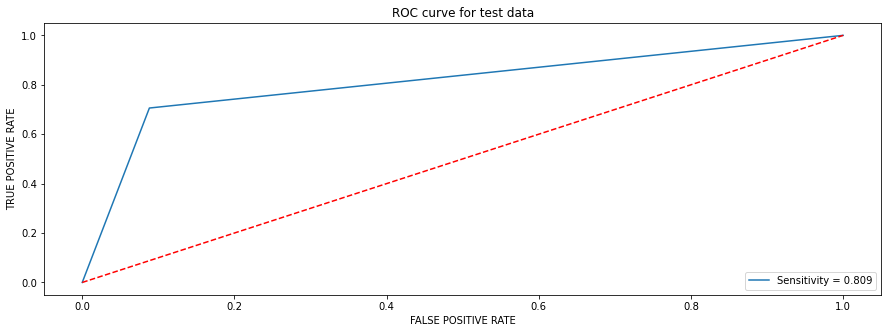

In [275]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_xgb)
roc_auc = roc_auc_score(y_test,y_pred_xgb)
plt.figure(figsize  = (15,5))
plt.plot(fpr, tpr, label = 'Sensitivity = %0.3f'% roc_auc )
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.title('ROC curve for test data')
plt.legend(loc="lower right")
plt.show()

No Skill: ROC AUC=0.500
XGBOOST: ROC AUC=0.897


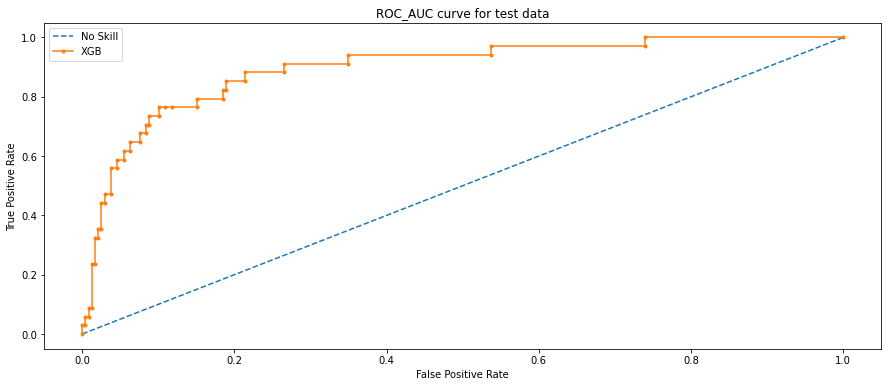

In [276]:
########### ROC  AUC curve   ######
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = gbm_best.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBOOST: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.figure(figsize = (15,6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("ROC_AUC curve for test data")
plt.show()  

XGBOOST: f1=0.608 auc=0.570


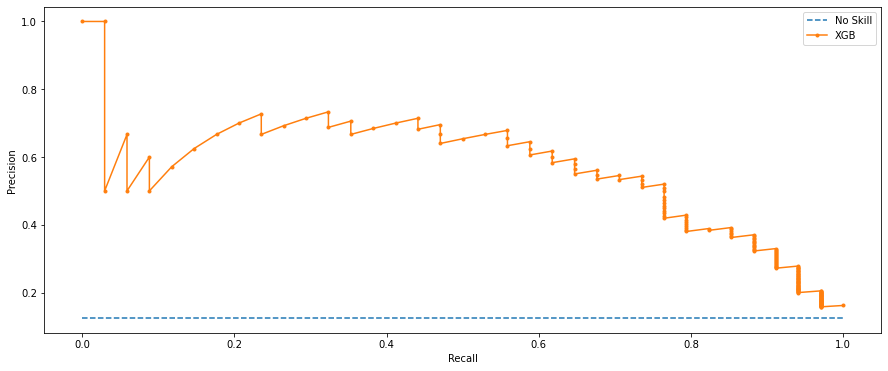

In [277]:
# Precision Recall curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, y_pred_xgb), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==1]) / len(y_test)
# summarize scores
print('XGBOOST: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
plt.figure(figsize=(15,6))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Ensembling

In [278]:
from sklearn.ensemble import VotingClassifier

In [279]:
#create a dictionary of our models
estimators=[("log_reg",classifier_lr), ("rf",rf_random), ("xgb_best",gbm_best)]

In [280]:
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting="soft")

In [281]:
#fit model to training data
ensemble.fit(X_train, y_train)
y_ensemble = ensemble.predict(X_test)

[03:48:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [282]:
#test our model on the test data
ensemble.score(X_test, y_test)

0.8860294117647058

In [283]:
confusion_matrix(y_ensemble, y_test)

array([[217,  10],
       [ 21,  24]], dtype=int64)

In [284]:
print("Training set accuracy : {}\nConfusion matrix :\n {}\nFull Report :\n{}\nroc_auc_score : {}".format(accuracy_score(y_ensemble,y_test),confusion_matrix(y_ensemble,y_test),classification_report(y_ensemble,y_test),roc_auc_score(y_ensemble,y_test)))

Training set accuracy : 0.8860294117647058
Confusion matrix :
 [[217  10]
 [ 21  24]]
Full Report :
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       227
           1       0.71      0.53      0.61        45

    accuracy                           0.89       272
   macro avg       0.81      0.74      0.77       272
weighted avg       0.88      0.89      0.88       272

roc_auc_score : 0.7446402349486049
